# Eyes Diseases classifiction using MobileNetV3

In [1]:
#import data by kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
#kaggle api
!kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification

100% 734M/736M [00:23<00:00, 40.1MB/s]
100% 736M/736M [00:23<00:00, 32.6MB/s]


In [3]:
#file unzip
import zipfile
zip_ref = zipfile.ZipFile('/content/eye-diseases-classification.zip') 
zip_ref.extractall('/content/Data')
zip_ref.close()

In [4]:
#importing the libery
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from  keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Dropout,Dense,Flatten,MaxPooling2D
from keras.callbacks import EarlyStopping 

In [5]:
#dataset path
path = "/content/Data/dataset"

In [6]:
#dataset spliting dataset train and test
train_data=tf.keras.preprocessing.image_dataset_from_directory(path,validation_split=0.2,
                                                               image_size=(224,224),
                                                               batch_size=32,
                                                               subset="training",
                                                               seed=123)

test_data=tf.keras.preprocessing.image_dataset_from_directory(path,validation_split=0.2,
                                                               image_size=(224,224),
                                                               batch_size=32,
                                                               subset="validation",
                                                               seed=123)

Found 4217 files belonging to 4 classes.
Using 3374 files for training.
Found 4217 files belonging to 4 classes.
Using 843 files for validation.


In [7]:
#check class
class_names = train_data.class_names
class_names

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

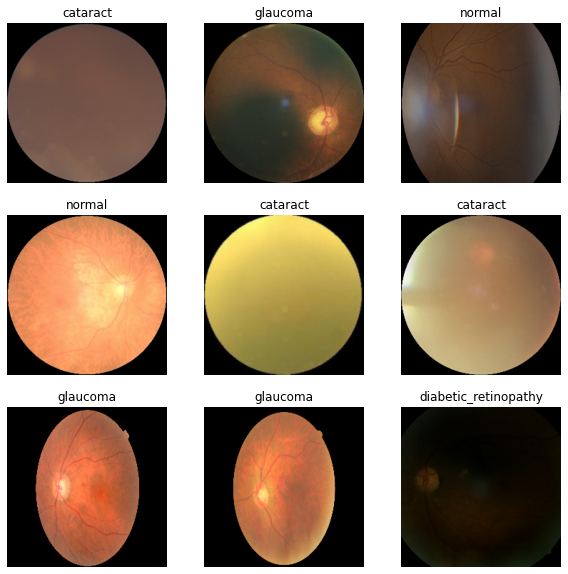

In [8]:
#dataset plot
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [9]:
# Criando o modelo base em cima do modelo MobileNetV3
base_model = keras.applications.MobileNetV3Small(input_shape=(224, 224, 3),
                                            classes=400,
                                            include_top=False,
                                            weights='imagenet')

4334752/4334752 [==============================] - 0s 0us/step


In [10]:
# Freeze convolutional base
base_model.trainable = False
base_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

In [11]:
#data augmentation
data_augmentation = keras.models.Sequential([
  keras.layers.RandomFlip('horizontal'),
  keras.layers.RandomRotation(0.2)
])

In [12]:
num_classes = len(class_names)# 7

inputs = keras.Input(shape=(224, 224, 3))
#x = data_augmentation(inputs)
x = keras.applications.mobilenet_v3.preprocess_input(inputs)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)


outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [13]:
#compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 4)                 2308      
                                                                 
Total params: 941,428
Trainable params: 2,308
Non-trainable p

In [14]:
#fitting model
initial_epochs = 15

early_stop = keras.callbacks.EarlyStopping(patience=1, restore_best_weights=True)

history = model.fit(train_data, 
          validation_data=test_data,
          epochs=initial_epochs,
          callbacks=[early_stop])

Epoch 1/15
106/106 [==============================] - 33s 211ms/step - loss: 0.9354 - accuracy: 0.5972 - val_loss: 0.5884 - val_accuracy: 0.7829
Epoch 2/15
106/106 [==============================] - 21s 181ms/step - loss: 0.6164 - accuracy: 0.7564 - val_loss: 0.4845 - val_accuracy: 0.8197
Epoch 3/15
106/106 [==============================] - 20s 180ms/step - loss: 0.5302 - accuracy: 0.7958 - val_loss: 0.4343 - val_accuracy: 0.8363
Epoch 4/15
106/106 [==============================] - 21s 190ms/step - loss: 0.4911 - accuracy: 0.8148 - val_loss: 0.4029 - val_accuracy: 0.8600
Epoch 5/15
106/106 [==============================] - 21s 185ms/step - loss: 0.4522 - accuracy: 0.8308 - val_loss: 0.3836 - val_accuracy: 0.8636
Epoch 6/15
106/106 [==============================] - 21s 190ms/step - loss: 0.4329 - accuracy: 0.8394 - val_loss: 0.3650 - val_accuracy: 0.8695
Epoch 7/15
106/106 [==============================] - 21s 182ms/step - loss: 0.4200 - accuracy: 0.8394 - val_loss: 0.3613 - val_ac

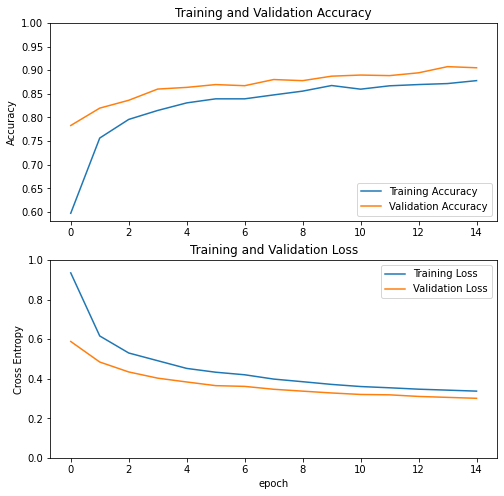

In [15]:
#check accurcy score and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

1/1 [==============================] - 1s 757ms/step


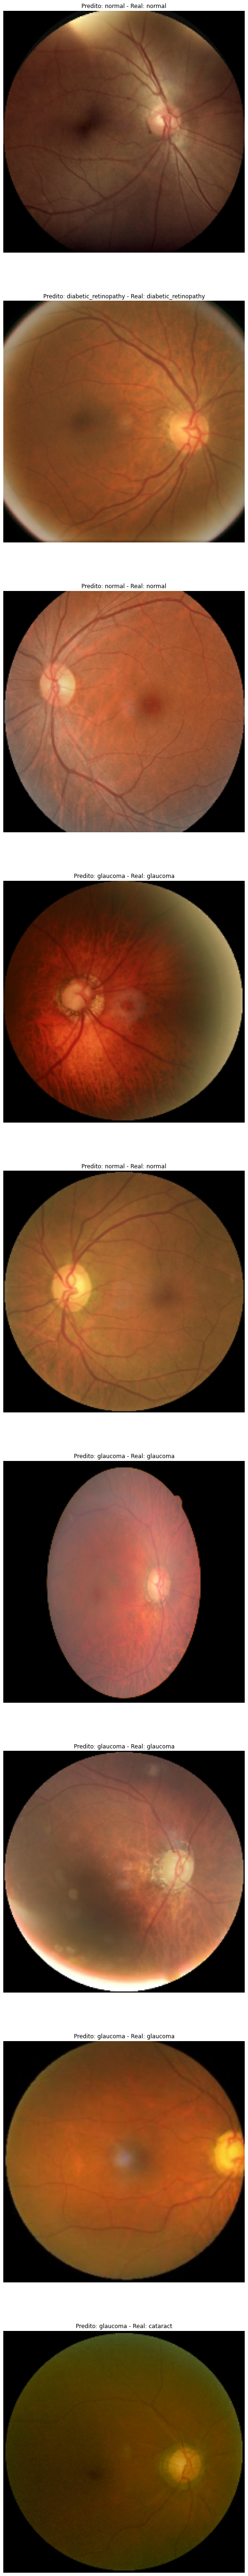

In [16]:
#check over model
plt.figure(figsize=(10, 100))
for images, labels in test_data.take(1):
    prediction = model.predict(images,batch_size=32)
    for i in range(9):
        ax = plt.subplot(9, 1, i+1)
        pred = np.argmax(prediction[i])
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(f'Predito: {class_names[pred]} - Real: {class_names[labels[i]]}')
        plt.axis('off')

In [18]:
#Visualize the result
results = model.evaluate(test_data, verbose=0)

In [19]:
print("Test Loss: {:.5f}".format(results[0]))
print("Accuracy on the test set: {:.2f}%".format(results[1] * 100))

Test Loss: 0.30095
Accuracy on the test set: 90.51%


In [27]:
#model save
model.save('/content/drive/MyDrive/Colab Notebooks/Eyes_diease.h5')